## 進階機器學習 HW2
* 學號: B103040047
* 姓名: 周安

### Predict the digit number of the image.

In [2]:
# !mkdir -p HW2_MNIST_train
# !unzip HW2_MNIST_train.zip -d HW2_MNIST_train

In [3]:
# !mkdir -p HW2_MNIST_test
# !unzip HW2_MNIST_test.zip -d HW2_MNIST_test

In [4]:
%matplotlib inline

In [5]:
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

import os
from torchsummary import summary
import time

In [6]:
import random

import torch
import numpy as np

# for reproduce rsult
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(2025)

In [7]:
# Hyper Parameters
LR = 0.001
batch_size_train = 200
batch_size_val = 200
batch_size_test = 200
NUM_EPOCHS = 30

IMAGE_SIZE = 32 # original image is 128x128
compose = [
    transforms.ToPILImage(),
    transforms.Lambda(lambda img: img.convert("RGB")), # remove Alpha, turn 4 channels into 3 channels
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize after grayscale conversion
    transforms.ToTensor(),
    # transforms.Normalize(mean=(0.5,), std=(0.5,)),  # Update mean/std for 1 channel
]
transform = transforms.Compose(compose)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Train on {device}.")

Train on cuda.


In [8]:
class MNISTDataset(Dataset):
    def __init__(self, dir, transform, type="train"):
        self.transform = transform
        self.dir = dir
        self.fnames = [os.path.join(dir, i) for i in os.listdir(dir) if i.endswith(".png")]
        self.num_samples = len(self.fnames)
        self.type = type
    def __getitem__(self,idx):
        fname = self.fnames[idx]
        # 1. Load the image
        img = torchvision.io.read_image(fname)
        # 2. Resize and normalize the images using torchvision.
        img = self.transform(img)
        if self.type == "train":
            txt_fname = fname.split(".")[0] + ".txt"
            # Open the file and read the line
            with open(txt_fname, "r") as file:
                line = file.readline().strip()  # Read the first line and remove whitespace

            # Split the values by tab (\t) or space
            label = list(map(float, line.split()))[0]  # Convert each to
            label = torch.tensor(label, dtype=torch.long)
        else:
            label = 0 # not used
        return img, label

    def __len__(self):
        return self.num_samples

    def get_filename(self, idx):
        if 0 <= idx < self.num_samples:
            return self.fnames[idx]
        else:
            raise IndexError("Index out of range")


### Define Model

In [9]:
# define CNN model
class CNN_model_MNIST(nn.Module):
    def __init__(self):
        super(CNN_model_MNIST, self).__init__()
        self.conv_layers = nn.Sequential(
                nn.Conv2d(1, 8, 3), # kernel = 5*5
                nn.BatchNorm2d(8),
                nn.ReLU(),
                nn.MaxPool2d(2, stride=2),
                nn.Conv2d(8, 16, 3), # kernel = 5*5
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(2, stride=2),
            )
        # final layer output above is (8, 108, 108) 93312
        self.classifier_layers = nn.Sequential(
                # Flatten layers
                nn.Linear(16*6*6, 256),
                nn.ReLU(),
                nn.Linear(256, 10)
            )


    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 16*6*6)
        x = self.classifier_layers(x)
        return x

img.shape : torch.Size([4, 128, 128])


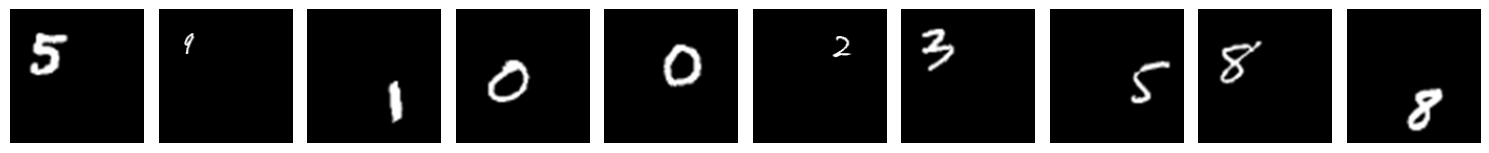

In [10]:
file_paths = [f for f in os.listdir("HW2_MNIST_train") if f.endswith(".png")]
np.random.shuffle(file_paths)
# for i in file_paths[:10]:
#     print(i)
img = torchvision.io.read_image("HW2_MNIST_train/0000000.png")
print("img.shape :", img.shape)

# Set up a 1-row, 10-column grid
num_images = 10
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# turn tensor into PIL image for showing
to_pil = transforms.ToPILImage()

# Loop through the first 10 images and display them
for i in range(num_images):
    img = torchvision.io.read_image(os.path.join("HW2_MNIST_train", file_paths[i]))  # Read as Tensor
    pil_img = to_pil(img)  # Convert Tensor to PIL Image
    axes[i].imshow(pil_img, cmap="gray")  # Show image
    axes[i].axis("off")  # Hide axis

plt.tight_layout()  # Adjust layout
plt.show()  # Show all images in a single figure

Test On transform action

In [11]:
to_gray = transforms.Grayscale(num_output_channels=1)
img = torchvision.io.read_image("HW2_MNIST_train/0000000.png")
print("img.shape :", np.array(img).shape)
img = to_pil(img)
print("img.shape :", np.array(img).shape)
img = img.convert("RGB")
print("img.shape :", np.array(img).shape)
img = to_gray(img)
print("img.shape :", np.array(img).shape)

img.shape : (4, 128, 128)
img.shape : (128, 128, 4)
img.shape : (128, 128, 3)
img.shape : (128, 128)


Prepare dataset & dataloader.  
Split the origin train dataset into 70% and 30%.

In [12]:
total_train_dataset = MNISTDataset("HW2_MNIST_train", transform, "train")
test_dataset = MNISTDataset("HW2_MNIST_test", transform, "test")

print("length of total_train_datast:", len(total_train_dataset))
print("length of test_datast:", len(test_dataset))
# Define split sizes
train_size = int(0.7 * len(total_train_dataset))  # 70% for training
val_size = len(total_train_dataset) - train_size  # Remaining 30% for validation

# Split dataset
train_dataset, val_dataset = random_split(total_train_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False, pin_memory=True)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False, pin_memory=True)
total_train_dataloader = DataLoader(total_train_dataset, batch_size=batch_size_train, shuffle=False, pin_memory=True)

length of total_train_datast: 97396
length of test_datast: 24350


See some picture and test if dataset work

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 32, 32])
torch.Size([3, 138, 138])


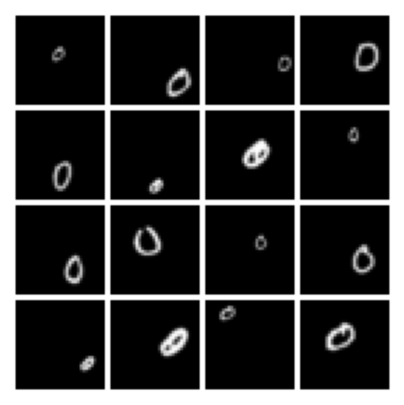

In [13]:
images = [total_train_dataset[i][0] for i in range(16)]
print(images[0].shape)
grid_img = torchvision.utils.make_grid(images, nrow=4, padding=2, pad_value=255)
print(grid_img.shape)
plt.figure(figsize=(5,5))
plt.imshow(grid_img.permute(1, 2, 0)) # Convert (C, H, W) -> (H, W, C)
plt.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 32, 32])
torch.Size([3, 138, 138])


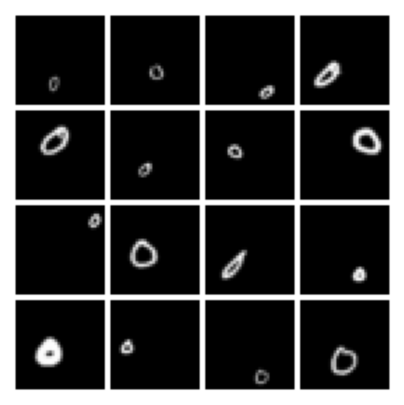

In [14]:
images = [test_dataset[i][0] for i in range(16)]
print(images[0].shape)
grid_img = torchvision.utils.make_grid(images, nrow=4, padding=2, pad_value=255)
print(grid_img.shape)
plt.figure(figsize=(5,5))
plt.imshow(grid_img.permute(1, 2, 0)) # Convert (C, H, W) -> (H, W, C)
plt.axis("off")
plt.show()

### Training

In [15]:
model = CNN_model_MNIST().to(device)

# pth_path = 'MNIST_model.pth'
# state_dict = torch.load(pth_path)
# model.load_state_dict(state_dict)
# print(f"Load pth from {pth_path}")

# set loss function
criterion = nn.CrossEntropyLoss()
# set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.999))
# let the LR decay after 10 epochs
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
# Print the model summary
summary(model, (1, IMAGE_SIZE, IMAGE_SIZE)) # Input size: (channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 30, 30]              80
       BatchNorm2d-2            [-1, 8, 30, 30]              16
              ReLU-3            [-1, 8, 30, 30]               0
         MaxPool2d-4            [-1, 8, 15, 15]               0
            Conv2d-5           [-1, 16, 13, 13]           1,168
       BatchNorm2d-6           [-1, 16, 13, 13]              32
              ReLU-7           [-1, 16, 13, 13]               0
         MaxPool2d-8             [-1, 16, 6, 6]               0
            Linear-9                  [-1, 256]         147,712
             ReLU-10                  [-1, 256]               0
           Linear-11                   [-1, 10]           2,570
Total params: 151,578
Trainable params: 151,578
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [16]:
from tqdm import tqdm
# train and val func for one epoch
def train_epoch(train_dataloader):
    train_loss = 0.0
    train_acc = 0.0
    model.train()
    for x, y in tqdm(train_dataloader):
        x, y = x.to(device), y.to(device)
        # clear gradients
        optimizer.zero_grad()
        # predicting
        y_pred = model(x)
        # see loss
        loss = criterion(y_pred, y)
        loss.backward()
        # update the parameters
        optimizer.step()

        # Update the LR
        # scheduler.step()

        train_loss += loss.item()
        probs = torch.nn.functional.softmax(y_pred, dim=1)
        train_acc += torch.sum(torch.argmax(probs, dim=1) == y).item()
    return train_acc / len(train_dataloader.dataset), train_loss / len(train_dataloader.dataset)

def val_epoch(val_dataloader):
    val_loss = 0.0
    val_acc = 0.0
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(val_dataloader):
            x, y = x.to(device), y.to(device)
            # predicting
            y_pred = model(x)
            # see loss
            loss = criterion(y_pred, y)

            val_loss += loss.item()
            probs = torch.nn.functional.softmax(y_pred, dim=1)
            val_acc += torch.sum(torch.argmax(probs, dim=1) == y).item()
    return val_acc / len(val_dataloader.dataset), val_loss / len(val_dataloader.dataset)

def test(test_dataloader, type="test"):
    pred_labels = []
    total_probs = []
    true_labels = [] # for testing train dataset
    model.eval()
    with torch.no_grad():
        if type == "test":
            for x, _ in tqdm(test_dataloader):
                x = x.to(device)
                # predicting
                y_pred = model(x)
                probs = torch.nn.functional.softmax(y_pred, dim=1)
                pred_labels.extend(torch.argmax(probs, dim=1).cpu().tolist())
            return pred_labels

        else:
            for x, y in tqdm(test_dataloader):
                x = x.to(device)
                # predicting
                y_pred = model(x)
                probs = torch.nn.functional.softmax(y_pred, dim=1)
                total_probs.append(probs)
                pred_labels.extend(torch.argmax(probs, dim=1).cpu().tolist())
                true_labels.extend(y.cpu().tolist())
            return torch.cat(total_probs, dim=0), pred_labels, true_labels

In [17]:
def plt_loss_accuracy_fig(Total_training_loss, Total_validation_loss, Total_training_accuracy, Total_validation_accuracy):
    # visualization the loss and accuracy
    plt.figure()
    plt.plot(range(len(Total_training_loss)), Total_training_loss, 'b-', label='Training_loss')
    plt.plot(range(len(Total_validation_loss)), Total_validation_loss, 'g-', label='validation_loss')
    plt.title('Training & Validation loss')
    plt.xlabel('No. of epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(range(len(Total_training_accuracy)), Total_training_accuracy, 'r-', label='Training_accuracy')
    plt.plot(range(len(Total_validation_accuracy)), Total_validation_accuracy, 'y-', label='Validation_accuracy')
    plt.title('Training & Validation accuracy')
    plt.xlabel('No. of epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [18]:
# Start training and testing
max_accuracy = 0
# For ploting the trend image
total_train_acc = []
total_val_acc = []
total_train_loss = []
total_val_loss = []
for i in range(NUM_EPOCHS):
    train_acc, train_loss = train_epoch(train_dataloader)
    val_acc, val_loss = val_epoch(val_dataloader)
    # record the training data
    total_train_acc.append(train_acc)
    total_val_acc.append(val_acc)

    total_train_loss.append(train_loss)
    total_val_loss.append(val_loss)

    print("Epoch[{:>2d}/{:>2d}] : train_acc = {:.4f}, train_loss = {:.4f}, val_acc = {:.4f}, val_loss = {:.4f}".format(i+1, NUM_EPOCHS, train_acc, train_loss, val_acc, val_loss))
    # update model pth when larger val_acc happens
    if(val_acc > max_accuracy):
        max_accuracy = val_acc
        save_parameters = True
        if save_parameters:
            path = 'MNIST_model.pth'
            torch.save(model.state_dict(), path)
            print("\t\33[33m====Save model parameters in {:s} when val_acc is {:.4f}====\33[0m".format(path, val_acc))

# save the final epoch's model
path = 'MNIST_model_final_epoch.pth'
torch.save(model.state_dict(), path)
print("\t\33[33m====Save FINAL model parameters in {:s}====\33[0m".format(path))

100%|██████████| 147/147 [00:15<00:00,  9.78it/s]


Epoch[ 1/30] : train_acc = 0.4661, train_loss = 0.0075, val_acc = 0.5367, val_loss = 0.0068
	====Save model parameters in MNIST_model.pth when val_acc is 0.5367====


100%|██████████| 147/147 [00:12<00:00, 11.73it/s]


Epoch[ 2/30] : train_acc = 0.7347, train_loss = 0.0040, val_acc = 0.7272, val_loss = 0.0040
	====Save model parameters in MNIST_model.pth when val_acc is 0.7272====


100%|██████████| 147/147 [00:12<00:00, 11.85it/s]


Epoch[ 3/30] : train_acc = 0.8049, train_loss = 0.0030, val_acc = 0.7957, val_loss = 0.0031
	====Save model parameters in MNIST_model.pth when val_acc is 0.7957====


100%|██████████| 147/147 [00:13<00:00, 10.97it/s]


Epoch[ 4/30] : train_acc = 0.8413, train_loss = 0.0024, val_acc = 0.7258, val_loss = 0.0044


100%|██████████| 147/147 [00:12<00:00, 11.72it/s]


Epoch[ 5/30] : train_acc = 0.8623, train_loss = 0.0021, val_acc = 0.8081, val_loss = 0.0029
	====Save model parameters in MNIST_model.pth when val_acc is 0.8081====


100%|██████████| 147/147 [00:16<00:00,  9.18it/s]


Epoch[ 6/30] : train_acc = 0.8778, train_loss = 0.0019, val_acc = 0.8545, val_loss = 0.0022
	====Save model parameters in MNIST_model.pth when val_acc is 0.8545====


100%|██████████| 147/147 [00:12<00:00, 11.89it/s]


Epoch[ 7/30] : train_acc = 0.8929, train_loss = 0.0016, val_acc = 0.8392, val_loss = 0.0025


100%|██████████| 147/147 [00:12<00:00, 11.58it/s]


Epoch[ 8/30] : train_acc = 0.8998, train_loss = 0.0015, val_acc = 0.8252, val_loss = 0.0027


100%|██████████| 147/147 [00:17<00:00,  8.41it/s]


Epoch[ 9/30] : train_acc = 0.9088, train_loss = 0.0014, val_acc = 0.8292, val_loss = 0.0026


100%|██████████| 147/147 [00:15<00:00,  9.44it/s]


Epoch[10/30] : train_acc = 0.9148, train_loss = 0.0013, val_acc = 0.8553, val_loss = 0.0022
	====Save model parameters in MNIST_model.pth when val_acc is 0.8553====


100%|██████████| 147/147 [00:18<00:00,  8.01it/s]


Epoch[11/30] : train_acc = 0.9208, train_loss = 0.0012, val_acc = 0.8761, val_loss = 0.0020
	====Save model parameters in MNIST_model.pth when val_acc is 0.8761====


100%|██████████| 147/147 [00:12<00:00, 11.79it/s]


Epoch[12/30] : train_acc = 0.9276, train_loss = 0.0011, val_acc = 0.5223, val_loss = 0.0139


100%|██████████| 147/147 [00:15<00:00,  9.53it/s]


Epoch[13/30] : train_acc = 0.9314, train_loss = 0.0010, val_acc = 0.8716, val_loss = 0.0021


100%|██████████| 147/147 [00:12<00:00, 11.77it/s]


Epoch[14/30] : train_acc = 0.9357, train_loss = 0.0009, val_acc = 0.8550, val_loss = 0.0024


100%|██████████| 147/147 [00:12<00:00, 11.87it/s]


Epoch[15/30] : train_acc = 0.9408, train_loss = 0.0009, val_acc = 0.8778, val_loss = 0.0021
	====Save model parameters in MNIST_model.pth when val_acc is 0.8778====


100%|██████████| 147/147 [00:14<00:00, 10.39it/s]


Epoch[16/30] : train_acc = 0.9433, train_loss = 0.0008, val_acc = 0.7929, val_loss = 0.0040


100%|██████████| 147/147 [00:12<00:00, 11.76it/s]


Epoch[17/30] : train_acc = 0.9481, train_loss = 0.0008, val_acc = 0.8156, val_loss = 0.0034


100%|██████████| 147/147 [00:12<00:00, 11.55it/s]


Epoch[18/30] : train_acc = 0.9512, train_loss = 0.0007, val_acc = 0.8630, val_loss = 0.0024


100%|██████████| 147/147 [00:12<00:00, 11.53it/s]


Epoch[19/30] : train_acc = 0.9532, train_loss = 0.0007, val_acc = 0.8792, val_loss = 0.0021
	====Save model parameters in MNIST_model.pth when val_acc is 0.8792====


100%|██████████| 147/147 [00:12<00:00, 11.67it/s]


Epoch[20/30] : train_acc = 0.9571, train_loss = 0.0006, val_acc = 0.8766, val_loss = 0.0022


100%|██████████| 147/147 [00:13<00:00, 11.29it/s]


Epoch[21/30] : train_acc = 0.9581, train_loss = 0.0006, val_acc = 0.8742, val_loss = 0.0023


100%|██████████| 147/147 [00:12<00:00, 11.77it/s]


Epoch[22/30] : train_acc = 0.9603, train_loss = 0.0006, val_acc = 0.8742, val_loss = 0.0023


100%|██████████| 147/147 [00:12<00:00, 11.71it/s]


Epoch[23/30] : train_acc = 0.9660, train_loss = 0.0005, val_acc = 0.8432, val_loss = 0.0030


100%|██████████| 147/147 [00:12<00:00, 11.63it/s]


Epoch[24/30] : train_acc = 0.9680, train_loss = 0.0005, val_acc = 0.8480, val_loss = 0.0031


100%|██████████| 147/147 [00:12<00:00, 11.32it/s]


Epoch[25/30] : train_acc = 0.9677, train_loss = 0.0005, val_acc = 0.8722, val_loss = 0.0025


100%|██████████| 147/147 [00:12<00:00, 11.63it/s]


Epoch[26/30] : train_acc = 0.9691, train_loss = 0.0005, val_acc = 0.8064, val_loss = 0.0043


100%|██████████| 147/147 [00:16<00:00,  8.66it/s]


Epoch[27/30] : train_acc = 0.9726, train_loss = 0.0004, val_acc = 0.7695, val_loss = 0.0051


100%|██████████| 147/147 [00:12<00:00, 11.84it/s]


Epoch[28/30] : train_acc = 0.9748, train_loss = 0.0004, val_acc = 0.8800, val_loss = 0.0025
	====Save model parameters in MNIST_model.pth when val_acc is 0.8800====


100%|██████████| 147/147 [00:12<00:00, 11.70it/s]


Epoch[29/30] : train_acc = 0.9753, train_loss = 0.0004, val_acc = 0.8704, val_loss = 0.0027


100%|██████████| 147/147 [00:12<00:00, 11.66it/s]

Epoch[30/30] : train_acc = 0.9765, train_loss = 0.0004, val_acc = 0.8402, val_loss = 0.0038
	====Save FINAL model parameters in MNIST_model_final_epoch.pth====


### Plot trend of acc and loss during process of training.

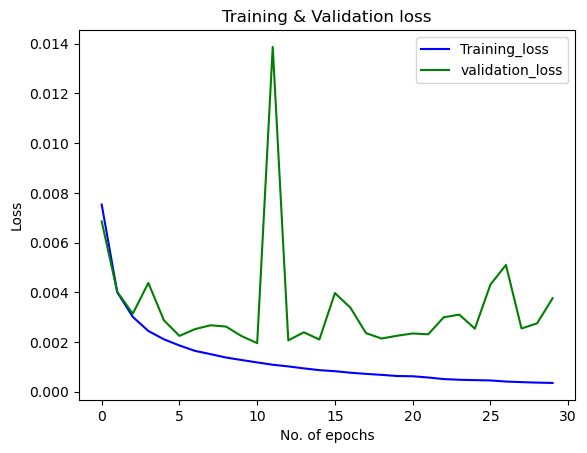

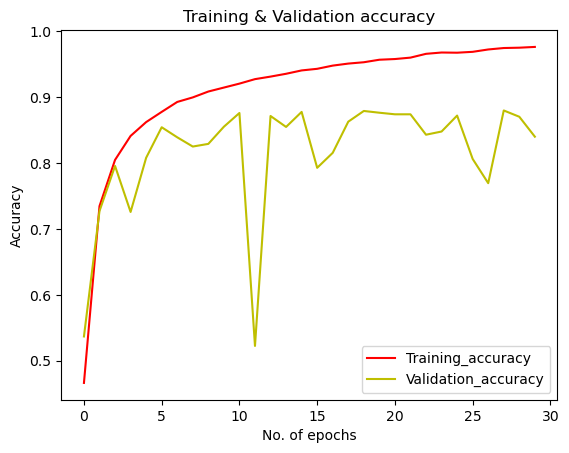

In [19]:
plt_loss_accuracy_fig(total_train_loss, total_val_loss, total_train_acc, total_val_acc)

In [20]:
def plot_confusion_matrix(pred_labels, true_labels, num_classes=10):
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=np.arange(num_classes))

    # Plot the confusion matrix using seaborn heatmap
    plt.figure(figsize=(7, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))

    # Add labels and title
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

### Finally test on total train dataset.  
1. Get:
* confusion matrix
* top-1 acc
* top-3 acc

In [21]:
# Reload the best model
model = CNN_model_MNIST().to(device)

pth_path = 'MNIST_model.pth'
state_dict = torch.load(pth_path)
model.load_state_dict(state_dict)
print(f"Load pth from {pth_path}")


Load pth from MNIST_model.pth


100%|██████████| 487/487 [00:41<00:00, 11.61it/s]


Top-1 Accuracy: 0.9467
Top-3 Accuracy: 0.9933


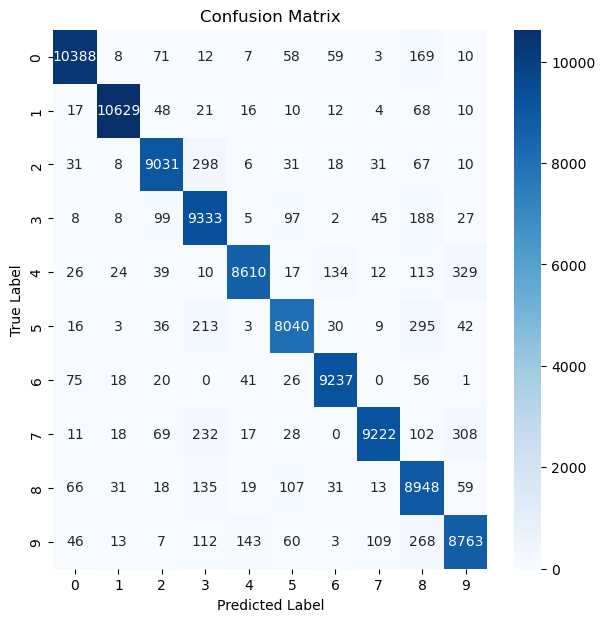

In [22]:
total_train_probs, train_pred_labels, true_labels = test(total_train_dataloader, type="train")

top_1_acc = 0.0
top_3_acc = 0.0
num_samples = len(true_labels)

for probs, label in zip(total_train_probs, true_labels):
    # Get top 3 predictions
    top3_probs, top3_indices = torch.topk(probs, 3, dim=0, largest=True, sorted=True)

    # Top-1 accuracy: if the top-1 predicted class matches the true label
    if top3_indices[0] == label:
        top_1_acc += 1

    # Top-3 accuracy: if the true label is among the top 3 predicted classes
    if label in top3_indices:
        top_3_acc += 1

# Calculate the final accuracy
top_1_acc /= num_samples
top_3_acc /= num_samples

print(f"Top-1 Accuracy: {top_1_acc:.4f}")
print(f"Top-3 Accuracy: {top_3_acc:.4f}")

plot_confusion_matrix(train_pred_labels, true_labels)

2. List **number of layers and parameters** used in your architecture.  
* Calculate the value of $$\frac{top-1\ accuracy}{\# of parameters}$$

In [23]:
def get_num_layers_and_params(model):
    num_layers = 0
    num_params = 0

    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.BatchNorm2d, nn.Linear, nn.ReLU, nn.MaxPool2d)):
            num_layers += 1  # Count only meaningful layers

        # Sum up the parameters only from leaf modules (actual layers, not containers)
        if len(list(module.children())) == 0:  # Ensures we are not counting Sequential itself
            num_params += sum(p.numel() for p in module.parameters() if p.requires_grad)

    return num_layers, num_params

# Get number of layers and parameters
num_layers, num_params = get_num_layers_and_params(model)
print(f"Number of layers: {num_layers}")
print(f"Number of parameters: {num_params}")
print(f"top-1 accuracy / # of parameters: {top_1_acc / num_params:.10f}")



Number of layers: 11
Number of parameters: 151578
top-1 accuracy / # of parameters: 0.0000062454


### Test on test dataset
3. Output the prediction result

In [25]:
import pandas as pd

# result dict storing the testing result
dict_test = {
    "image": [],
    "class": []
}

pred_labels = test(test_dataloader, type="test")
if len(pred_labels) !=  len(test_dataset):
    print(len(pred_labels), len(test_dataset))
    print("\33[35mError: Not available results.\33[0m")
# prepare for getting dataframe
for i in range(len(test_dataset)):
    dict_test["image"].append(test_dataset.get_filename(i).split("\\")[1]) # access the filename
    dict_test["class"].append(pred_labels[i])

csv_path = 'HW2_prob1.csv'
df = pd.DataFrame(dict_test)
df.to_csv(csv_path,index=False)
print("Successfully write into {:s} file.".format(csv_path))

100%|██████████| 122/122 [00:08<00:00, 15.04it/s]

Successfully write into HW2_prob1.csv file.
